In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from concurrent.futures import ThreadPoolExecutor

In [2]:
df = pd.read_csv('Datasets/predict-dropout-or-academic-success.csv')

In [3]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


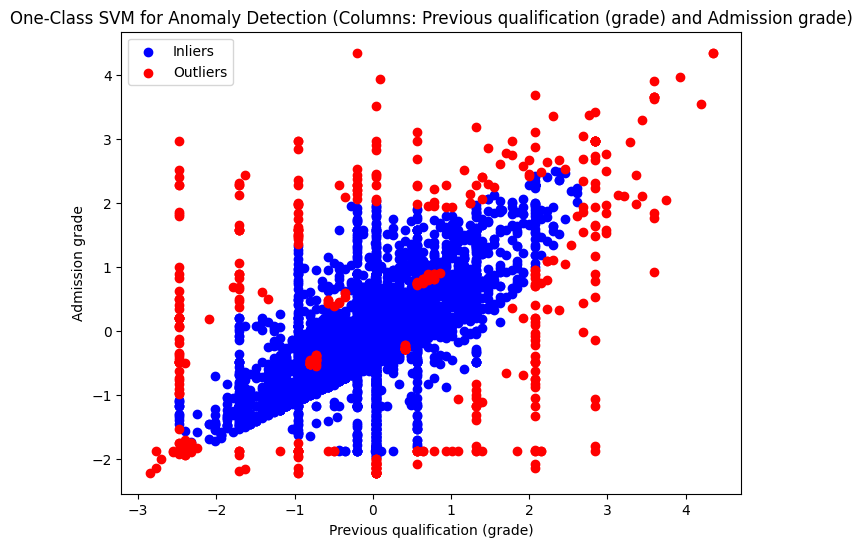

In [12]:
x_column = 'Previous qualification (grade)'
y_column = 'Admission grade'

# Extract the selected columns
data = df[[x_column, y_column]]

# Standardise the data
scaler = StandardScaler()
data_norm = scaler.fit_transform(data)

model = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.6)
model.fit(data_norm)

# Predict anomalies, outliers = -1
y_pred = model.predict(data_norm)

plt.figure(figsize=(8, 6))

# Inliers
plt.scatter(data_norm[y_pred == 1, 0], data_norm[y_pred == 1, 1], color='blue', label='Inliers')

# Outliers
plt.scatter(data_norm[y_pred == -1, 0], data_norm[y_pred == -1, 1], color='red', label='Outliers')

plt.title(f"One-Class SVM for Anomaly Detection (Columns: {x_column} and {y_column})")
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.legend()
plt.show()


In [ ]:
cols = ['Absences','GPA']
num_data = df[cols]

# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_data)

# Apply One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma=0.7, nu=0.01)
svm_labels = svm_model.fit_predict(scaled_data)

# Add SVM labels to the original data
df['svm_label'] = svm_labels

# Filter rows considered anomalous
anomalous_data = df[df['svm_label'] == -1]

# Display the anomalous rows
print(anomalous_data)

In [5]:
class OCSVM:
    def __init__(self, nu=0.1, kernel='rbf', gamma=1.0):
        self.nu = nu
        self.kernel = kernel
        self.gamma = gamma

    def _kernel_function(self, X, Y=None):
        # Computer the kernel matrix
        if Y is None:
            Y = X
        if self.kernel == 'rbf':
            # Approximate RBF kernel using Random Fourier Features
            n_features = 100  # Dimensionality of approximation
            rng = np.random.default_rng(seed=42)
            omega = rng.normal(0, np.sqrt(2 * self.gamma), size=(X.shape[1], n_features))
            b = rng.uniform(0, 2 * np.pi, size=n_features)
            X_proj = np.cos(X @ omega + b)
            Y_proj = np.cos(Y @ omega + b) if Y is not X else X_proj
            return X_proj @ Y_proj.T
        elif self.kernel == 'linear':
            # Linear kernel
            return np.dot(X, Y.T)
        elif self.kernel == 'poly':
            # Polynomial kernel
            return (np.dot(X, Y.T) + 1) ** 3
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X):
        n_samples = X.shape[0]
        K = self._kernel_function(X)

        # Define the quadratic programming problem
        P = matrix(K)
        q = matrix(-np.ones((n_samples, 1)))
        
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) / (self.nu * n_samples))))
        
        A = matrix(1.0, (1, n_samples)) # Equaltiy constraint
        b = matrix(1.0)

        # Solve quadratic programming problem
        sol = solvers.qp(P, q, G, h, A, b)

        # Extract Lagrange multipliers (alphas)
        alphas = np.array(sol['x']).flatten()
        support_vector_indices = alphas > 1e-5
        self.alphas = alphas[support_vector_indices]
        self.support_vectors = X[support_vector_indices]
        self.K_sv = K[support_vector_indices][:, support_vector_indices]
        
        # Compute the intercept term
        self.rho = np.mean(self.K_sv @ self.alphas)

    def decision_function(self, X):
        # Compute the decision function
        K_test = self._kernel_function(X, self.support_vectors)
        return np.sum(K_test * self.alphas, axis=1) - self.rho

    def predict(self, X):
        # Predict whether the data is an inlier or an outlier
        return np.sign(self.decision_function(X))
    
    
    def plot(self, X):
        predictions = self.predict(X)
        inliers = X[predictions == 1]
        outliers = X[predictions == -1]

        # Print IDs of outliers
        outlier_ids = np.where(predictions == -1)[0]
        print("Outlier IDs:", outlier_ids)

        plt.figure(figsize=(8, 6))
        plt.scatter(inliers[:, 0], inliers[:, 1], c='blue', label='Inliers', s=20)
        plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers', s=20)
        plt.title('One-Class SVM Results')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.grid(True)
        plt.show()

     pcost       dcost       gap    pres   dres
 0:  6.0144e-01 -1.0518e+01  1e+04  1e+02  5e-15
 1:  7.5867e-01 -1.0255e+01  9e+02  8e+00  4e-15
 2:  1.2579e+00 -1.0500e+01  3e+02  2e+00  3e-15
 3:  1.8924e+00 -9.4275e+00  8e+01  6e-01  3e-15
 4:  2.4361e+00 -6.1090e+00  2e+01  1e-01  4e-15
 5:  2.7080e+00  7.9726e-01  2e+00  2e-03  4e-15
 6:  2.6145e+00  2.1311e+00  5e-01  5e-04  4e-15
 7:  2.5864e+00  2.3181e+00  3e-01  2e-04  3e-15
 8:  2.5682e+00  2.4269e+00  1e-01  1e-04  3e-15
 9:  2.5621e+00  2.4594e+00  1e-01  6e-05  3e-15
10:  2.5571e+00  2.4837e+00  7e-02  4e-05  3e-15
11:  2.5511e+00  2.5153e+00  4e-02  1e-05  3e-15
12:  2.5505e+00  2.5179e+00  3e-02  6e-06  3e-15
13:  2.5486e+00  2.5241e+00  2e-02  5e-06  3e-15
14:  2.5477e+00  2.5276e+00  2e-02  3e-06  3e-15
15:  2.5466e+00  2.5317e+00  1e-02  4e-07  3e-15
16:  2.5458e+00  2.5337e+00  1e-02  2e-07  3e-15
17:  2.5446e+00  2.5364e+00  8e-03  1e-07  3e-15
18:  2.5438e+00  2.5380e+00  6e-03  5e-08  3e-15
19:  2.5434e+00  2.53

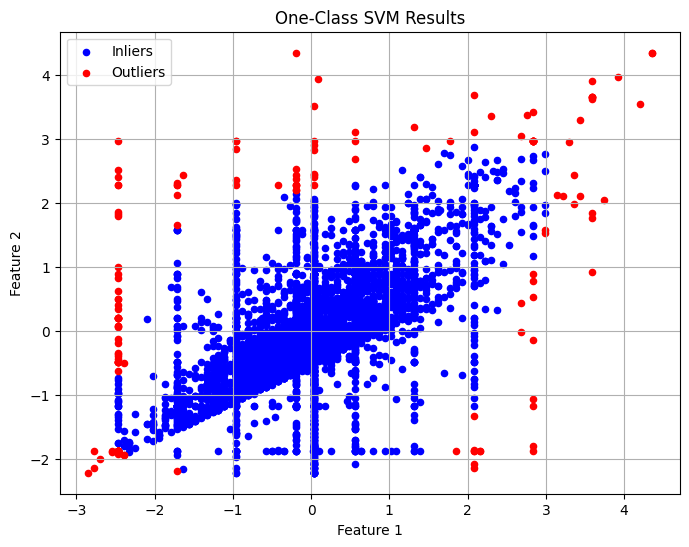

Predictions: [ 1.  1.  1. ...  1. -1.  1.]


In [7]:
data = df[['Previous qualification (grade)', 'Admission grade']]
data_norm = StandardScaler().fit_transform(data)

# Train custom One-Class SVM
oc_svm = OCSVM(nu=0.1, kernel='rbf', gamma=0.6)
oc_svm.fit(data_norm)
oc_svm.plot(data_norm)

# Predict on training data_norm
predictions = oc_svm.predict(data_norm)
print("Predictions:", predictions)
